In [ ]:
!unzip "/content/drive/MyDrive/kaggle/concrete_cracked_images.zip"

Streaming output truncated to the last 5000 lines.
  inflating: concrete_cracked_images/train/Positive/15001_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15002_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15003_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15004_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15005_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15006_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15007_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15008_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15009_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15010_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15011_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15012_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15013_1.jpg  
  inflating: concrete_cracked_images/train/Positive/15014_1.jpg  
  inflating: concrete_cra

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
from PIL import Image 
import cv2 
from keras_preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import Sequence 
import cv2 
from google.colab.patches import cv2_imshow 

import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Input
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
test=pd.read_csv("/content/concrete_cracked_images/Testing_set_concrete_crack.csv") 
sub=pd.read_csv("/content/concrete_cracked_images/sample_submission.csv")

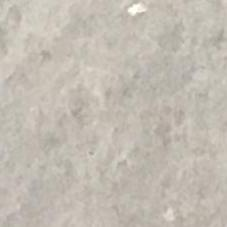

In [ ]:
image=cv2.imread('/content/concrete_cracked_images/test/Image_2.jpg')
cv2_imshow(image)

In [ ]:
image.shape

(227, 227, 3)

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 preprocessing_function=preprocess_input,
                                 validation_split=0.10)


train_generator=train_datagen.flow_from_directory(directory="/content/concrete_cracked_images/train", 
                                                  batch_size=100, 
                                                  seed=42, 
                                                  shuffle=True,
                                                  class_mode="categorical", 
                                                  target_size=(224,224),
                                                  subset="training")
valid_generator=train_datagen.flow_from_directory(directory="/content/concrete_cracked_images/train", 
                                                  batch_size=100, 
                                                  seed=42, 
                                                  shuffle=True, 
                                                  class_mode="categorical", 
                                                  target_size=(224,224),
                                                  subset="validation")

Found 25847 images belonging to 2 classes.
Found 2871 images belonging to 2 classes.


In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255,
                                preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(dataframe=test,
                                                  x_col="filename",
                                                  directory="/content/concrete_cracked_images/test/", 
    class_mode=None, target_size=(224,224), batch_size=1, shuffle = False)

Found 11282 validated image filenames.


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]
# add preprocessing layer to the front of VGG
vgg_16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False,pooling='avg')

In [ ]:
# don't train existing weights
for layer in vgg_16.layers:
  layer.trainable = False

In [ ]:
# our layers - you can add more if you want
x = tf.keras.layers.Flatten()(vgg_16.output)
prediction = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.models.Model(inputs=vgg_16.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
history=model.fit_generator(generator=train_generator,
                            epochs=3,
                            validation_data=valid_generator,
                            steps_per_epoch=train_generator.n//100,
                            validation_steps=valid_generator.n//100) #0.9978

Epoch 1/3
258/258 [==============================] - 117s 454ms/step - loss: 0.0704 - accuracy: 0.9887 - val_loss: 0.0717 - val_accuracy: 0.9850
Epoch 2/3
258/258 [==============================] - 117s 453ms/step - loss: 0.0561 - accuracy: 0.9906 - val_loss: 0.0606 - val_accuracy: 0.9864
Epoch 3/3
258/258 [==============================] - 117s 452ms/step - loss: 0.0470 - accuracy: 0.9916 - val_loss: 0.0517 - val_accuracy: 0.9864


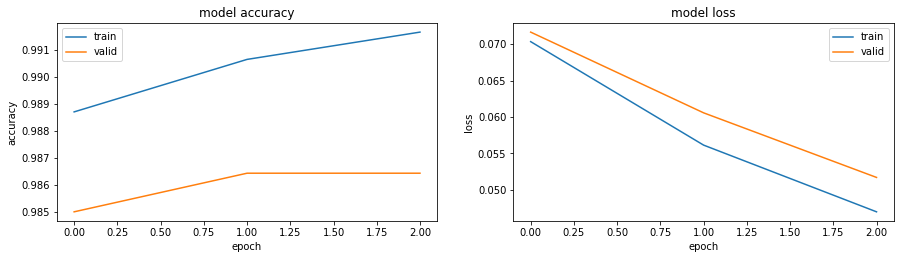

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [ ]:
model.save("model.h5")
print("Saved model to disk")

from tensorflow.keras.models import load_model
model_1 = load_model('model.h5')

Saved model to disk


In [ ]:
preds=model_1.predict(test_generator,batch_size=1)
preds_1=np.array([np.argmax(i) for i in preds])
sub['prediction']=np.where(preds_1>0,"Positive","Negative")
sub.to_csv('final_12.csv',index=False)

In [ ]:
sub.head()

,prediction
0,Negative
1,Negative
2,Negative
3,Negative
4,Positive
